
###### =============================================================================
#  LIBRARY INSTALLATION 
###### =============================================================================
#### Core Scientific Libraries
numpy
pandas
xarray
scikit-learn

#### Geospatial Libraries
geopandas
rioxarray
cartopy

#### Climate & Hydrology Libraries
climate-indices
pymannkendall

#### Wavelet Transform Library
PyWavelets

#### Plotting
matplotlib

In [ ]:
!pip install scikit-learn
!pip install geopandas  # !pip install 'geopandas[all]'
!pip install rioxarray
!pip install pymannkendall
!pip install cartopy
!pip install climate-indices
!pip install PyWavelets

In [29]:
import geopandas as gpd
print(gpd.__version__) # Output the version of geopandas

1.0.1


In [65]:
import os
import dask
import pywt

import xarray as xr
import rioxarray
import matplotlib.pyplot as plt
import geopandas as gpd
import pymannkendall as mk
import numpy as np
import pandas as pd
from scipy import stats
import cartopy.crs as ccrs
import pymannkendall as mk
import cartopy.feature as cfeature

from shapely.geometry import box, Point

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score

from itertools import groupby
from climate_indices import indices, compute, utils  # climate_indices package

import matplotlib.patches as mpatches

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


from sklearn.svm import SVR

from deap import base, creator, tools, algorithms
import random
import joblib
import warnings
warnings.filterwarnings("ignore")

#### Data Loading and Exploration ( NetCDF ) 


In [31]:
# Load precipitation datasets NetCDF
cru_data = xr.open_dataset("/Dataset/CRUPATH")
gpcc_data = xr.open_dataset("../Dataset/GPCCPATH")


# Ensure the datasets are loaded correctly
ds_cru = cru_data.sel(time=slice('1928-01-01', '2017-12-31'))
ds_gpcc = gpcc_data.sel(time=slice('1928-01-01', '2017-12-31'))

# Basic exploration
print("\nGPCC Data Info:")
print(ds_gpcc)
print(ds_cru.data_vars)
print(ds_cru.coords)
print(ds_cru.dims)
print(ds_cru.attrs)


GPCC Data Info:
<xarray.Dataset> Size: 653MB
Dimensions:                       (time: 1080, lon: 140, lat: 180)
Coordinates:
  * time                          (time) datetime64[ns] 9kB 1928-01-01 ... 20...
  * lon                           (lon) float64 1kB 0.125 0.375 ... 34.62 34.88
  * lat                           (lat) float64 1kB 24.88 24.62 ... -19.88
Data variables:
    precip                        (time, lat, lon) float32 109MB ...
    numgauge                      (time, lat, lon) float32 109MB ...
    infilled_numgauges            (time, lat, lon) float32 109MB ...
    interpolation_error           (time, lat, lon) float32 109MB ...
    interpolation_error_infilled  (time, lat, lon) float32 109MB ...
    diff_new_old_method           (time, lat, lon) float32 109MB ...
Attributes: (12/20)
    CDI:                       Climate Data Interface version 1.9.8 (https://...
    Conventions:               CF-1.4
    history:                   Sat Mar 15 13:03:58 2025: cdo sellonla

#### ECCAS Region Selection

- Each ECCAS country has a unique three-letter code available in the ISO_A3 column of WORLD dataset. 

In [3]:
# Load country boundaries
url50 = "https://naciscdn.org/naturalearth/50m/cultural/ne_50m_admin_0_countries.zip"   
world = gpd.read_file(url50)

# Filter ECCAS countries
ceeac_iso3 = ["AGO","BDI","CMR","COG","GAB","GNQ","CAF","COD","RWA","STP","TCD"]
ceeac_gdf = world[world["ISO_A3"].isin(ceeac_iso3)]
print(ceeac_gdf[["ADMIN","ISO_A3"]].values)

[['São Tomé and Principe' 'STP']
 ['Rwanda' 'RWA']
 ['Gabon' 'GAB']
 ['Equatorial Guinea' 'GNQ']
 ['Democratic Republic of the Congo' 'COD']
 ['Republic of the Congo' 'COG']
 ['Chad' 'TCD']
 ['Central African Republic' 'CAF']
 ['Cameroon' 'CMR']
 ['Burundi' 'BDI']
 ['Angola' 'AGO']]


- Merge all ECCAS geometries into a single one

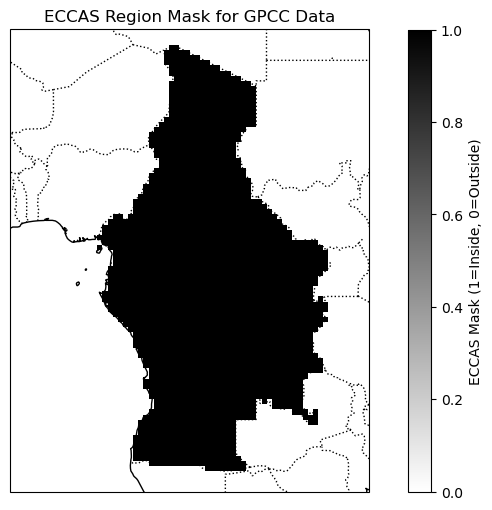

Selected ECCAS countries:
['São Tomé and Principe' 'Rwanda' 'Gabon' 'Eq. Guinea' 'Dem. Rep. Congo'
 'Congo' 'Chad' 'Central African Rep.' 'Cameroon' 'Burundi' 'Angola']

Dimensions of filtered CRU data:
Time: 1080 months
Latitudes: 90 points
Longitudes: 70 points

Dimensions of filtered GPCC data:
Time: 1080 months
Latitudes: 180 points
Longitudes: 140 points


In [32]:

ceeac_union = ceeac_gdf.geometry.union_all()

def create_ceeac_mask(ds, region_geom):
    """Create a 2D boolean mask for the ECCAS region"""
    lon, lat = np.meshgrid(ds.lon.values, ds.lat.values)
    mask = np.zeros(lon.shape, dtype=bool)
    
    for i in range(lat.shape[0]):
        for j in range(lat.shape[1]):
            point = Point(lon[i, j], lat[i, j])
            mask[i, j] = region_geom.contains(point)
    
    return xr.DataArray(mask, dims=('lat', 'lon'), coords={'lat': ds.lat, 'lon': ds.lon})

# Apply the ECCAS mask to CRU and GPCC
ceeac_cru_mask = create_ceeac_mask(ds_cru, ceeac_union)
ds_cru_ceeac = ds_cru.where(ceeac_cru_mask)

ceeac_gpcc_mask = create_ceeac_mask(ds_gpcc, ceeac_union)
ds_gpcc_ceeac = ds_gpcc.where(ceeac_gpcc_mask)

# Visualize the mask to verify ECCAS coverage (GPCC)
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ceeac_cru_mask.plot(ax=ax, cmap='binary', add_colorbar=True, cbar_kwargs={'label': 'ECCAS Mask (1=Inside, 0=Outside)'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
plt.title('ECCAS Region Mask for GPCC Data')
plt.show()

print("Selected ECCAS countries:")
print(ceeac_gdf['NAME'].values)

print("\nDimensions of filtered CRU data:")
print(f"Time: {len(ds_cru_ceeac.time)} months")
print(f"Latitudes: {len(ds_cru_ceeac.lat)} points")
print(f"Longitudes: {len(ds_cru_ceeac.lon)} points")

ds_cru_ceeac.to_netcdf("../Dataset/CEEAC_cru_filtered.nc")

print("\nDimensions of filtered GPCC data:")
print(f"Time: {len(ds_gpcc_ceeac.time)} months")
print(f"Latitudes: {len(ds_gpcc_ceeac.lat)} points")
print(f"Longitudes: {len(ds_gpcc_ceeac.lon)} points")

ds_gpcc_ceeac.to_netcdf("../Dataset/CEEAC_gpcc_filtered.nc")


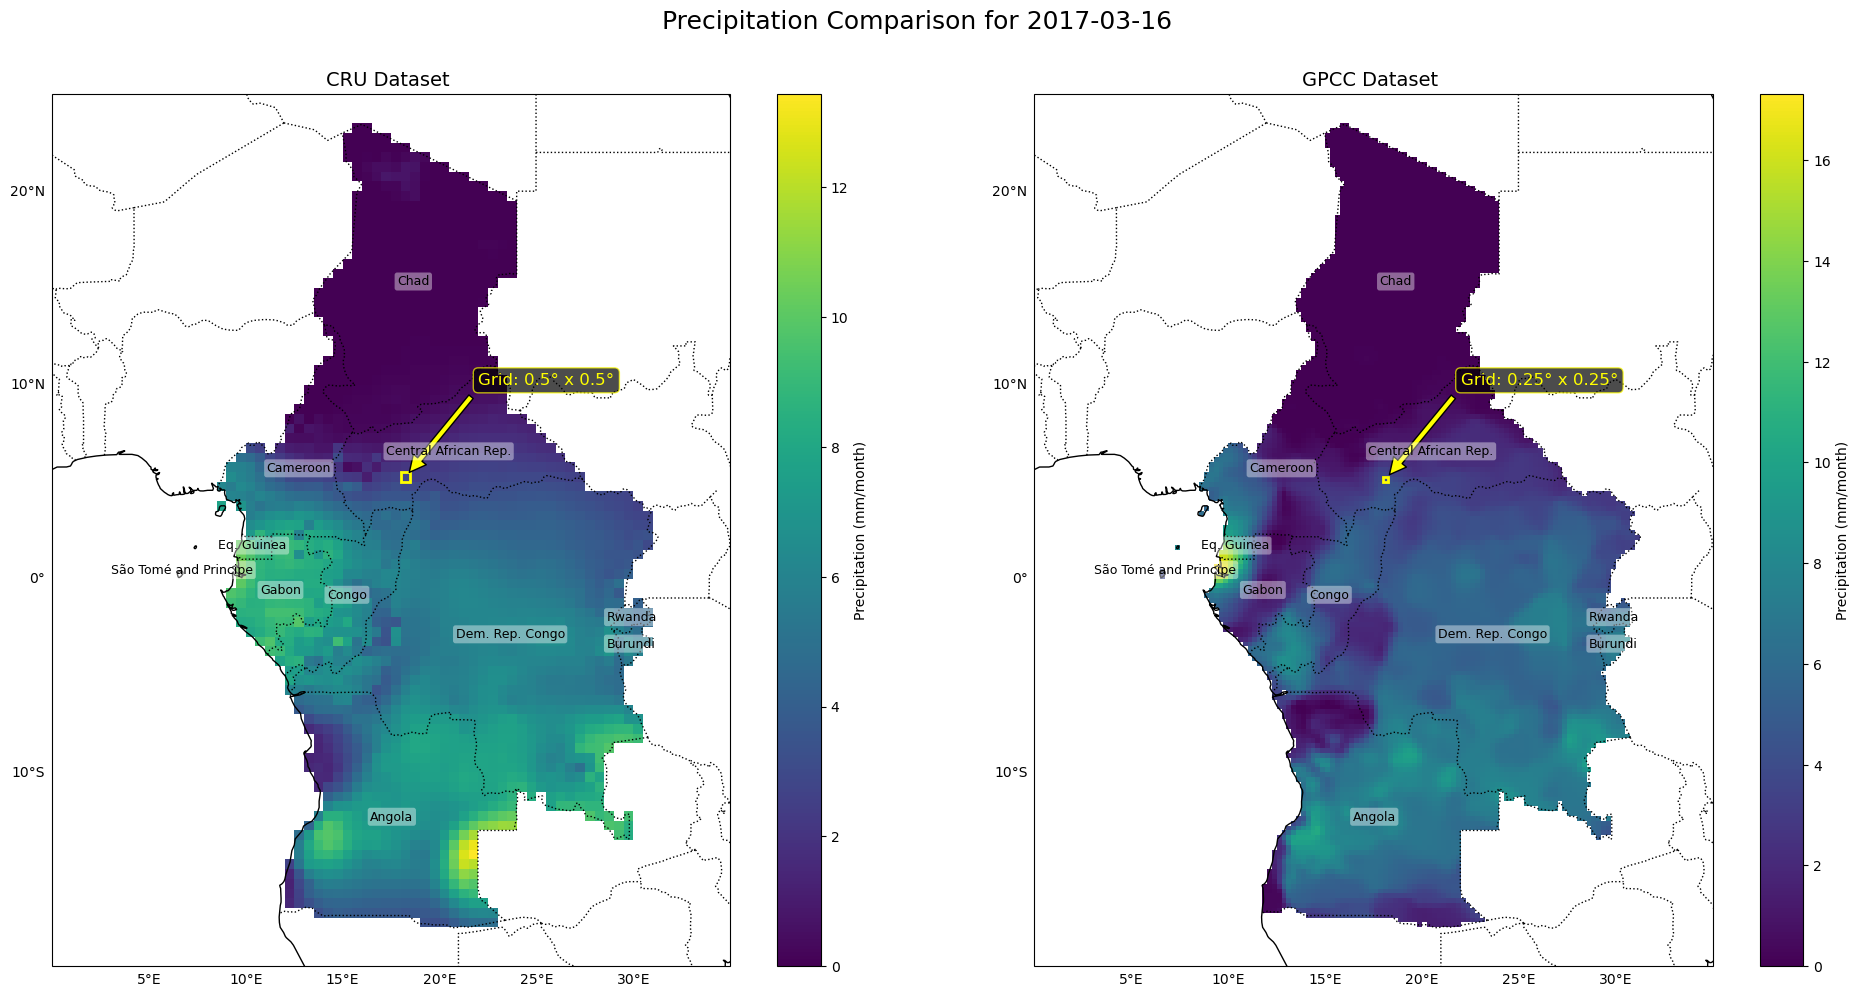

In [6]:
# Note: In a 1928-2017 monthly dataset, time index 1070 is March 2017.
time_index = 1070 # From 0 to 1079 
time_string = ds_cru_ceeac.time.isel(time=time_index).dt.strftime('%Y-%m-%d').item()

fig, axes = plt.subplots(
    1, 2,
    figsize=(20, 10),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
fig.suptitle(f"Precipitation Comparison for {time_string}", fontsize=18)

# Plot 1: CRU Data 
ax1 = axes[0]
ds_cru_ceeac.pre.isel(time=time_index).plot(
    ax=ax1,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    cbar_kwargs={'label': 'Precipitation (mm/month)'}
)
ax1.set_title("CRU Dataset ", fontsize=14)

ax1.add_patch(mpatches.Rectangle(
    xy=[18, 5], width=0.5, height=0.5,
    facecolor='none',
    edgecolor='yellow',
    linewidth=2,
    transform=ccrs.PlateCarree()
))

ax1.annotate(
    'Grid: 0.5° x 0.5°',
    xy=(18.25, 5.25),
    xytext=(22, 10),
    color='yellow',
    fontsize=12,
    arrowprops=dict(facecolor='yellow', shrink=0.05),
    bbox=dict(boxstyle="round,pad=0.3", fc="black", ec="yellow", lw=1, alpha=0.7)
)


# Plot 2: GPCC Data 
ax2 = axes[1]
ds_gpcc_ceeac.precip.isel(time=time_index).plot(
    ax=ax2,
    transform=ccrs.PlateCarree(),
    cmap='viridis',
    cbar_kwargs={'label': 'Precipitation (mm/month)'}
)
ax2.set_title("GPCC Dataset ", fontsize=14)

ax2.add_patch(mpatches.Rectangle(
    xy=[18, 5], width=0.25, height=0.25,
    facecolor='none',
    edgecolor='yellow',
    linewidth=2,
    transform=ccrs.PlateCarree()
))

ax2.annotate(
    'Grid: 0.25° x 0.25°',
    xy=(18.125, 5.125),
    xytext=(22, 10),
    color='yellow',
    fontsize=12,
    arrowprops=dict(facecolor='yellow', shrink=0.05),
    bbox=dict(boxstyle="round,pad=0.3", fc="black", ec="yellow", lw=1, alpha=0.7)
)

for ax in axes:
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0, color='gray', alpha=0.5)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

    # Add country names to each plot
    for idx, row in ceeac_gdf.iterrows():
        centroid = row.geometry.centroid
        ax.text(centroid.x, centroid.y, row['NAME'],
                fontsize=9,
                color='black',
                ha='center',
                va='center',
                transform=ccrs.PlateCarree(),
                bbox=dict(facecolor='white', alpha=0.4, edgecolor='none', boxstyle='round,pad=0.2')
                )

plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

### SPI Calculation

In [7]:
periodicity = compute.Periodicity.monthly
scale        = 6
distribution = indices.Distribution.gamma
start_year   = 1928
end_year     = 2017

*Why use apply_ufunc?*

- When manipulating our data with NumPy, we observe shifts (dry/wet zones displaced, edges appearing differently pixelated). This is caused by the reshaping from 3D → 2D → 3D, which breaks spatial alignment. To avoid this issue, we should favor using apply_ufunc, as it guarantees point-to-point correspondence and preserves the spatial alignment.

In [34]:
def spi_1d(arr_1d):
    return indices.spi(
        arr_1d,
        scale,
        distribution,
        start_year,
        start_year,
        end_year,
        periodicity
    )

spi_cru_xr = xr.apply_ufunc(
    spi_1d,
    ds_cru_ceeac["pre"],
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
).rename("spi6_cru")

In [35]:
def spi_1d(arr):
    return indices.spi(
        arr,
        scale,
        distribution,
        start_year,
        start_year,
        end_year,
        periodicity
    )

spi_gpcc_xr = xr.apply_ufunc(
    spi_1d,                         
    ds_gpcc_ceeac["precip"],        
    input_core_dims=[["time"]],     
    output_core_dims=[["time"]],    
    vectorize=True,                 
    dask="parallelized",            
    output_dtypes=[float],         
).rename("spi6_gpcc")

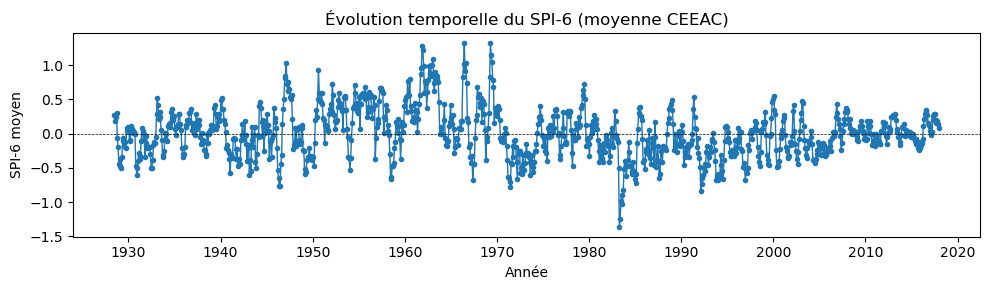

In [36]:
# Compute the spatial mean at each time step
spi_mean = spi_cru_xr.mean(dim=["lat","lon"], skipna=True)

plt.figure(figsize=(10,3))
spi_mean.plot.line(marker=".", linewidth=1)
plt.axhline(0, color="k", linestyle="--", linewidth=0.5)
plt.title("Évolution temporelle du SPI‑6 (moyenne CEEAC)")
plt.ylabel("SPI‑6 moyen")
plt.xlabel("Année")
plt.tight_layout()
plt.show()

*Drought Trend Analysis*

- Calculate annual or decadal SPI-6 means to identify trends.

- Perform statistical trend analysis (e.g., using the Mann-Kendall test from the pymannkendall library).

- A value of trend_*_global = –1 indicates a drying trend, while +1 indicates a wetting trend.

- The p-value will tell you whether the trend is statistically significant.

In [37]:
spi_gpcc_annual = spi_gpcc_xr.groupby("time.year").mean(dim=["lat","lon"])
spi_cru_annual  = spi_cru_xr .groupby("time.year").mean(dim=["lat","lon"])

series_gpcc = spi_gpcc_annual.values  # shape (n_years,)
series_cru  = spi_cru_annual.values

def mk_test_1d(x):
    y = x[~np.isnan(x)]
    if y.size < 3:
        print("Enter Here ??")
        return np.nan, np.nan
    r = mk.original_test(y)
    code = {"increasing":1, "decreasing":-1, "no trend":0}[r.trend]
    return code, r.p

trend_gpcc_global, p_gpcc_global = mk_test_1d(series_gpcc)
print(f"GPCC global trend: {trend_gpcc_global}, p-value: {p_gpcc_global}")
trend_cru_global,  p_cru_global  = mk_test_1d(series_cru)
print(f"CRU  global trend: {trend_cru_global}, p-value: {p_cru_global}")

GPCC global trend: -1, p-value: 1.247668635073751e-12
CRU  global trend: -1, p-value: 0.00029402921647991853


In [15]:
# Annual mean (dims = ('year', 'lat', 'lon'))
spi_gpcc_annual = spi_gpcc_xr.groupby("time.year").mean(dim="time")
spi_cru_annual  = spi_cru_xr .groupby("time.year").mean(dim="time")

# At this stage, dims = ('year', 'lat', 'lon') and the 'year' coordinate exists.
# Swap: replace the 'year' dimension with the 'year' coordinate, and rename it to 'time
spi_gpcc_annual = (
    spi_gpcc_annual
    .swap_dims({"year": "year"})      
    .rename({"year": "time"})         
    .assign_coords(time=spi_gpcc_annual["year"].values)
)

spi_cru_annual = (
    spi_cru_annual
    .swap_dims({"year": "year"})      
    .rename({"year": "time"})         
    .assign_coords(time=spi_cru_annual["year"].values)
)

print(spi_gpcc_annual.dims)  

# Define the MK test function
def mk_test_pixel(x):
    y = x[~np.isnan(x)]
    if y.size < 3:
        return np.nan, np.nan
    r = mk.original_test(y)
    code = {"increasing": 1, "decreasing": -1, "no trend": 0}[r.trend]
    return code, r.p

res = xr.apply_ufunc(
    mk_test_pixel,
    spi_gpcc_annual,            # DataArray(time,lat,lon)
    input_core_dims=[["time"]], 
    output_core_dims=[[], []],  # trend and p-value
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float, float]
)

res_ = xr.apply_ufunc(
    mk_test_pixel,
    spi_cru_annual,            
    input_core_dims=[["time"]], 
    output_core_dims=[[], []],  
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float, float]
)

trend_map_gpcc  = res[0].rename("trend")
pvalue_map_gpcc = res[1].rename("pvalue")

trend_map_cru  = res_[0].rename("trend")
pvalue_map_cru = res_[1].rename("pvalue")

# print(trend_map_gpcc.dims)    
# print(pvalue_map_gpcc.dims)   # ('lat','lon')


('lat', 'lon', 'time')


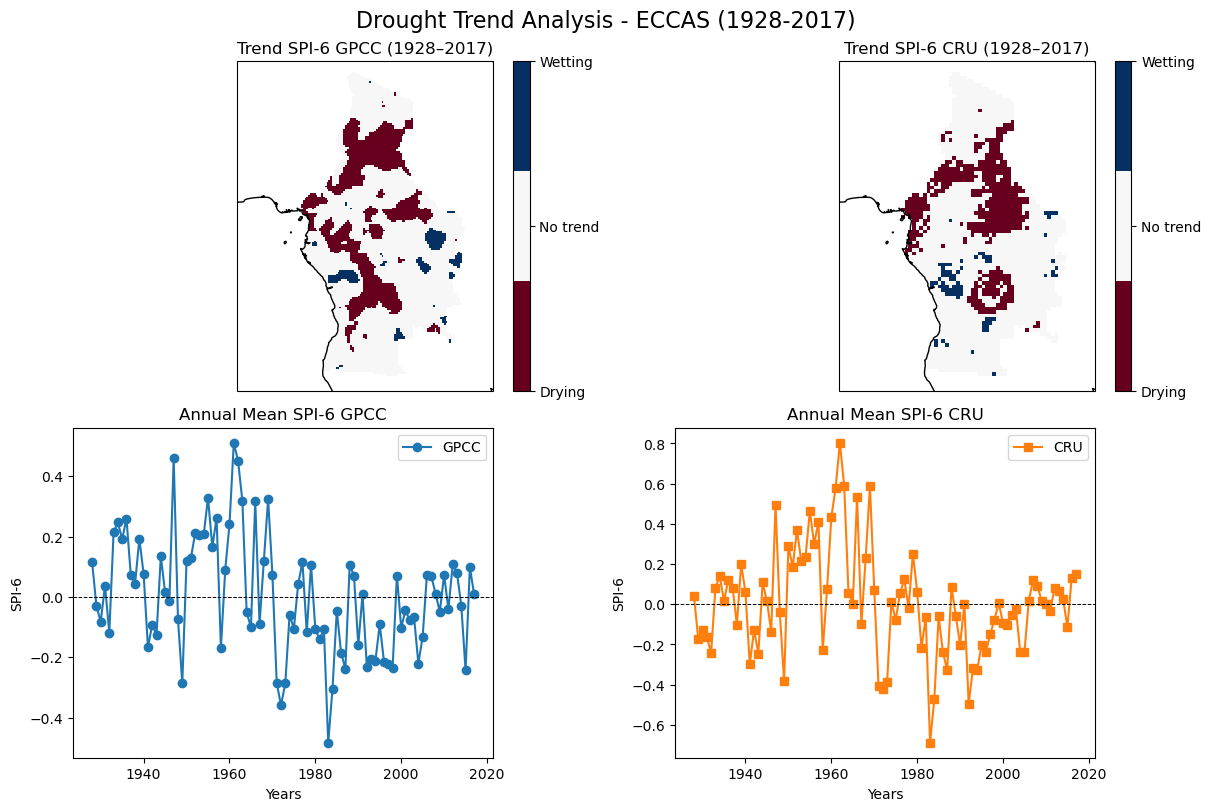

In [17]:
# Global time series (annual spatial mean)
gpcc_ts = spi_gpcc_annual.mean(dim=["lat","lon"])
cru_ts  = spi_cru_annual .mean(dim=["lat","lon"])
years   = gpcc_ts["time"].values

fig = plt.figure(figsize=(12, 8), constrained_layout=True)
proj = ccrs.PlateCarree()

# Top-left : carte de tendance GPCC
ax1 = fig.add_subplot(2, 2, 1, projection=proj)
cmap3 = plt.get_cmap("RdBu", 3)
pcm1 = ax1.pcolormesh(
    trend_map_gpcc.lon, trend_map_gpcc.lat, trend_map_gpcc,
    cmap=cmap3, vmin=-1, vmax=1,
    transform=proj
)
ax1.coastlines()
cb1 = fig.colorbar(pcm1, ax=ax1, ticks=[-1,0,1], orientation="vertical", pad=0.02)
cb1.ax.set_yticklabels(["Drying","No trend","Wetting"])
ax1.set_title("Trend SPI-6 GPCC (1928–2017)")


# Top-right : carte de tendance CRU
ax2 = fig.add_subplot(2, 2, 2, projection=proj)
pcm2 = ax2.pcolormesh(
    trend_map_cru.lon, trend_map_cru.lat, trend_map_cru,
    cmap=cmap3, vmin=-1, vmax=1,
    transform=proj
)
ax2.coastlines()
cb2 = fig.colorbar(pcm2, ax=ax2, ticks=[-1,0,1], orientation="vertical", pad=0.02)
cb2.ax.set_yticklabels(["Drying","No trend","Wetting"])
ax2.set_title("Trend SPI-6 CRU (1928–2017)")

# --- Bottom-left : série temporelle GPCC
ax3 = fig.add_subplot(2, 2, 3)
ax3.plot(years, gpcc_ts, marker="o", linestyle="-", label="GPCC")
ax3.axhline(0, color="k", linestyle="--", linewidth=0.7)
ax3.set_title("Annual Mean SPI-6 GPCC")
ax3.set_xlabel("Years")
ax3.set_ylabel("SPI-6")
ax3.legend()

# --- Bottom-right : série temporelle CRU
ax4 = fig.add_subplot(2, 2, 4)
ax4.plot(years, cru_ts, marker="s", linestyle="-", color="tab:orange", label="CRU")
ax4.axhline(0, color="k", linestyle="--", linewidth=0.7)
ax4.set_title("Annual Mean SPI-6 CRU")
ax4.set_xlabel("Years")
ax4.set_ylabel("SPI-6")
ax4.legend()

plt.suptitle("Drought Trend Analysis - ECCAS (1928-2017)", fontsize=16)
plt.show()


###### ==============================================================================================================================================================================
###  UNSUPERVISED LEARNING FOR SPATIO-TEMPORAL ANALYSIS
###### =============================================================================================================================================================

- Objective: Identify drought-prone zones in Central Africa.

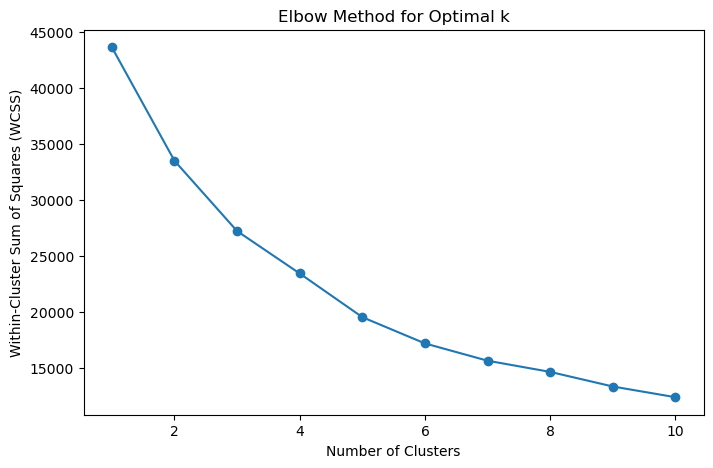

In [40]:
# SPI-6 calculation 
threshold = -1  # Moderate drought threshold

# Compute drought metrics
df_gpcc = (spi_gpcc_xr < threshold).mean(dim='time').rename('drought_frequency')

ds_gpcc = (-spi_gpcc_xr).where(spi_gpcc_xr < threshold, 0).sum(dim='time').rename('drought_severity')

def max_consecutive_drought_1d(spi_1d, threshold=-1):
    drought = spi_1d < threshold
    if not np.any(drought):
        return 0
    max_length = max(len(list(g)) for k, g in groupby(drought) if k)
    return max_length

mdd_gpcc = xr.apply_ufunc(
    max_consecutive_drought_1d,
    spi_gpcc_xr,
    input_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[int]
).rename('max_drought_duration')

# Prepare data for clustering, ensuring only ECCAS points are included
lat_gpcc = spi_gpcc_xr.lat.values
lon_gpcc = spi_gpcc_xr.lon.values
lon_grid_gpcc, lat_grid_gpcc = np.meshgrid(lon_gpcc, lat_gpcc)
lat_flat_gpcc = lat_grid_gpcc.flatten()
lon_flat_gpcc = lon_grid_gpcc.flatten()
df_flat_gpcc = df_gpcc.values.flatten()
ds_flat_gpcc = ds_gpcc.values.flatten()
mdd_flat_gpcc = mdd_gpcc.values.flatten()
mask_flat_gpcc = ceeac_gpcc_mask.values.flatten()

# Create feature matrix, including only points within ECCAS
features_gpcc = np.column_stack((lat_flat_gpcc, lon_flat_gpcc, df_flat_gpcc, ds_flat_gpcc, mdd_flat_gpcc))
mask_gpcc = mask_flat_gpcc & ~np.isnan(features_gpcc).any(axis=1)
features_clean_gpcc = features_gpcc[mask_gpcc]
coords_clean_gpcc = np.column_stack((lat_flat_gpcc[mask_gpcc], lon_flat_gpcc[mask_gpcc]))

# Normalize features
scaler = StandardScaler()
features_scaled_gpcc = scaler.fit_transform(features_clean_gpcc)

# Determine optimal number of clusters using elbow method
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled_gpcc)
    wcss.append(kmeans.inertia_)


# Plot elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', color='#1f77b4')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.show()


- Pearson Correlation Test
- Flatten the metrics arrays and apply the valid-point mask

In [42]:
print("\n--- Calculating Pearson correlation for drought metrics (GPCC) ---")

df_flat = df_gpcc.values.flatten()
ds_flat = ds_gpcc.values.flatten()
mdd_flat = mdd_gpcc.values.flatten()
mask_flat = ceeac_gpcc_mask.values.flatten()

valid_mask_df_ds = mask_flat & ~np.isnan(df_flat) & ~np.isnan(ds_flat)
corr_df_ds, p_value_df_ds = stats.pearsonr(df_flat[valid_mask_df_ds], ds_flat[valid_mask_df_ds])
print("Correlation between Frequency (DF) and Severity (DS):")
print(f"  Pearson coefficient: {corr_df_ds:.4f}")
print(f"  P-value: {p_value_df_ds}")



--- Calculating Pearson correlation for drought metrics (GPCC) ---
Correlation between Frequency (DF) and Severity (DS):
  Pearson coefficient: 0.8901
  P-value: 0.0


#### Performs advanced clustering of drought metrics over three historical subperiods:

In [44]:
# Define subperiods for the analysis
subperiods = {
    'p1': slice('1928-01-01', '1957-12-31'),
    'p2': slice('1958-01-01', '1987-12-31'),
    'p3': slice('1988-01-01', '2017-12-31')
}

# Color Palette
color_palettes = {
    'Arid':      ['#55372A', '#4A2C17', '#3D2010'],
    'Critical':  ['#8B0000', '#6E0000', '#4D0000'],
    'Severe':    ['#D92525', '#C21313', '#A10D0D'],
    'Warning':   ['#F37750', '#EE4D23', '#D93A0D'],
    'Moderate':  ['#FDCB9A', '#FAAC64', '#F78C2D'],
    'Attention': ['#FDD869', '#FBC11F', '#E9A200'],
    'Normal':    ['#FEFDE2', '#FCF7B8', '#FAEF8A']
}

# Metric Calculation 
def compute_all_metrics(precip_ds, spi_ds, threshold=-1):
    map_metric = (precip_ds.mean(dim='time') * 12).rename('mean_annual_precip')
    df_metric = (spi_ds < threshold).mean(dim='time').rename('drought_frequency')
    ds_metric = (-spi_ds).where(spi_ds < threshold, 0).sum(dim='time').rename('drought_severity')
    def max_consecutive_drought_1d(spi_1d, threshold_val):
        return max((len(list(g)) for k, g in groupby(spi_1d < threshold_val) if k), default=0)
    mdd_metric = xr.apply_ufunc(max_consecutive_drought_1d, spi_ds, input_core_dims=[["time"]], vectorize=True, dask="parallelized", output_dtypes=[int], kwargs={'threshold_val': threshold}).rename('max_drought_duration')
    return map_metric, df_metric, ds_metric, mdd_metric

# Advanced Clustering Function 
def perform_advanced_clustering(map_m, df_m, ds_m, mdd_m, mask, lat, lon, n_clusters=7, random_state=42):
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    lat_flat, lon_flat, mask_flat = lat_grid.flatten(), lon_grid.flatten(), mask.values.flatten()
    map_flat, df_flat, ds_flat, mdd_flat = map_m.values.flatten(), df_m.values.flatten(), ds_m.values.flatten(), mdd_m.values.flatten()

    arid_feature = -np.log1p(map_flat)
    clustering_features = np.column_stack((lat_flat, lon_flat, arid_feature, ds_flat, mdd_flat))
    all_metrics = np.column_stack((map_flat, df_flat, ds_flat, mdd_flat))

    valid_mask = mask_flat & ~np.isnan(clustering_features).any(axis=1)
    features_clean = clustering_features[valid_mask]
    metrics_clean = all_metrics[valid_mask]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_clean)
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10).fit(features_scaled)
    labels = kmeans.labels_
    sil_score = silhouette_score(features_scaled, labels)

    labels_full = np.full(lat_flat.shape, np.nan)
    labels_full[valid_mask] = labels
    labels_da = xr.DataArray(labels_full.reshape(lat_grid.shape), coords={'lat': lat, 'lon': lon}, dims=['lat', 'lon'])

    cluster_means = {}
    for i in range(n_clusters):
        cluster_data = metrics_clean[labels == i]
        cluster_means[i] = {'mean_map': np.mean(cluster_data[:,0]), 'mean_df': np.mean(cluster_data[:,1]), 'mean_ds': np.mean(cluster_data[:,2]), 'mean_mdd': np.mean(cluster_data[:,3])}

    arid_cluster_id = min(cluster_means, key=lambda k: cluster_means[k]['mean_map'])
    drought_clusters = {k: v for k, v in cluster_means.items() if k != arid_cluster_id}
    sorted_drought_clusters = sorted(drought_clusters.items(), key=lambda x: x[1]['mean_ds'], reverse=True)

    cluster_labels = {arid_cluster_id: 'Arid'}
    drought_labels = ['Critical', 'Severe', 'Warning', 'Moderate', 'Attention', 'Normal']
    for i, (cluster_id, _) in enumerate(sorted_drought_clusters):
        cluster_labels[cluster_id] = drought_labels[i]
        
    return labels_da, cluster_labels, sil_score, cluster_means, labels, valid_mask

# Function to map countries to clusters 
def get_countries_per_cluster(labels, valid_mask, lat_flat, lon_flat, gdf, n_clusters=7):
    countries_per_cluster = {i: set() for i in range(n_clusters)}
    coords_clean = np.column_stack((lon_flat[valid_mask], lat_flat[valid_mask]))
    
    for idx, label in enumerate(labels):
        lon, lat = coords_clean[idx]
        point = Point(lon, lat)
        for _, row in gdf.iterrows():
            
            if row.geometry.contains(point):
                countries_per_cluster[int(label)].add(row['NAME'])
                break
    return countries_per_cluster



--- DETAILED CLUSTER ANALYSIS ---

GPCC p1 Cluster Characteristics:
Cluster 0 (Attention):
  Mean Annual Precip: 52.0 mm/yr
  Mean Drought Frequency: 0.092
  Mean Drought Severity: 48.340
  Mean Max Drought Duration: 6.4 months
Cluster 1 (Severe):
  Mean Annual Precip: 31.3 mm/yr
  Mean Drought Frequency: 0.169
  Mean Drought Severity: 102.570
  Mean Max Drought Duration: 9.6 months
Cluster 2 (Arid):
  Mean Annual Precip: 1.5 mm/yr
  Mean Drought Frequency: 0.129
  Mean Drought Severity: 79.753
  Mean Max Drought Duration: 8.6 months
Cluster 3 (Critical):
  Mean Annual Precip: 53.9 mm/yr
  Mean Drought Frequency: 0.191
  Mean Drought Severity: 120.714
  Mean Max Drought Duration: 18.4 months
Cluster 4 (Normal):
  Mean Annual Precip: 23.6 mm/yr
  Mean Drought Frequency: 0.074
  Mean Drought Severity: 40.961
  Mean Max Drought Duration: 5.3 months
Cluster 5 (Moderate):
  Mean Annual Precip: 53.0 mm/yr
  Mean Drought Frequency: 0.139
  Mean Drought Severity: 77.875
  Mean Max Drought Dura

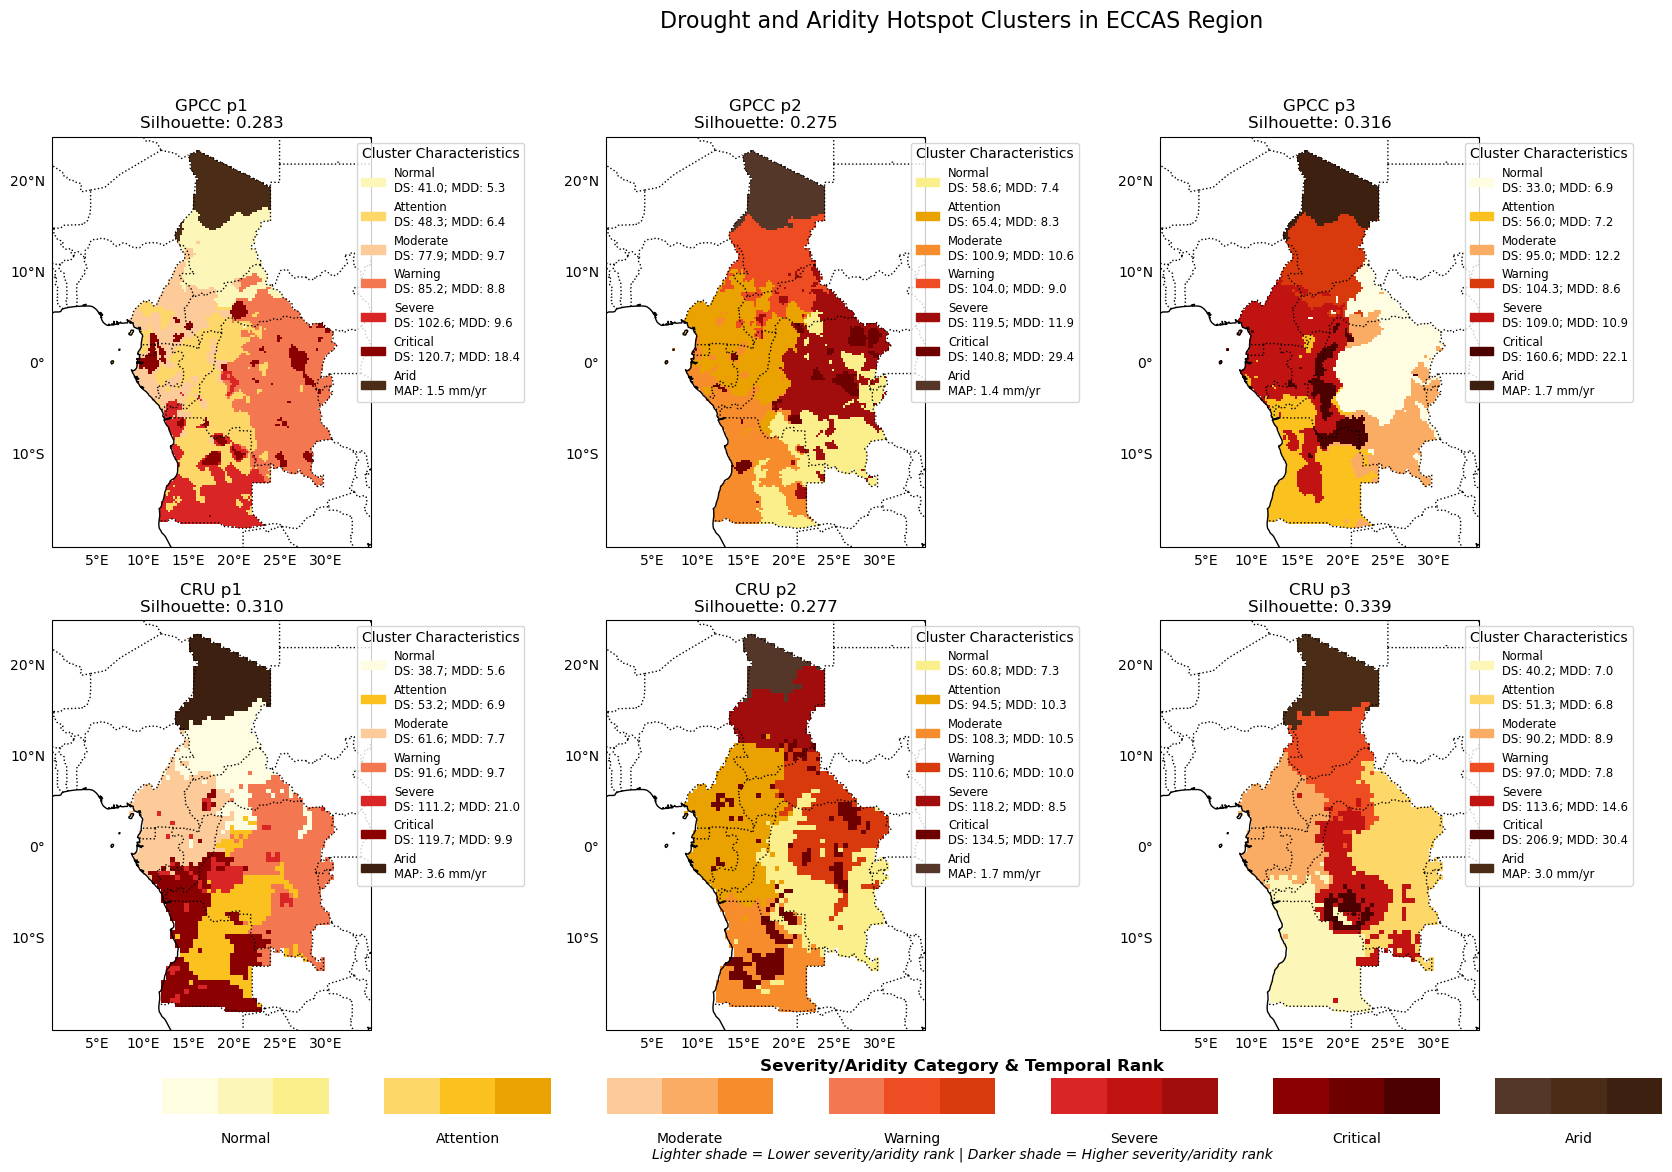

In [45]:
datasets_precip = {'GPCC': ds_gpcc_ceeac.precip, 'CRU': ds_cru_ceeac.pre}
datasets_spi = {'GPCC': spi_gpcc_xr, 'CRU': spi_cru_xr}
datasets_mask = {'GPCC': ceeac_gpcc_mask, 'CRU': ceeac_cru_mask}
results = {}

for dataset_name in ['GPCC', 'CRU']:
    precip_ds_full, spi_ds_full, mask = datasets_precip[dataset_name], datasets_spi[dataset_name], datasets_mask[dataset_name]
    lat, lon = spi_ds_full.lat.values, spi_ds_full.lon.values
    results[dataset_name] = {}
    
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    lat_flat, lon_flat = lat_grid.flatten(), lon_grid.flatten()
    
    for period_name, period_slice in subperiods.items():
        precip_sub, spi_sub = precip_ds_full.sel(time=period_slice), spi_ds_full.sel(time=period_slice)
        map_m, df_m, ds_m, mdd_m = compute_all_metrics(precip_sub, spi_sub)
        labels_da, cluster_labels, sil_score, cluster_means, labels, valid_mask = perform_advanced_clustering(
            map_m, df_m, ds_m, mdd_m, mask, lat, lon
        )
        countries = get_countries_per_cluster(labels, valid_mask, lat_flat, lon_flat, ceeac_gdf)
        results[dataset_name][period_name] = {
            'labels_da': labels_da, 'cluster_labels': cluster_labels, 'sil_score': sil_score, 
            'cluster_means': cluster_means, 'countries_per_cluster': countries
        }

# Temporal Ranking for Color Shading 
ds_values = {}
for dataset_name in ['GPCC', 'CRU']:
    ds_values[dataset_name] = {}
    for label in color_palettes.keys():
        ds_values[dataset_name][label] = {}
        for period_name in ['p1', 'p2', 'p3']:
            res = results[dataset_name][period_name]
            label_to_id = {v: k for k, v in res['cluster_labels'].items()}
            if label in label_to_id:
                cluster_id = label_to_id[label]
                value = res['cluster_means'][cluster_id]['mean_map'] if label == 'Arid' else res['cluster_means'][cluster_id]['mean_ds']
                ds_values[dataset_name][label][period_name] = value

ranks = {}
for dataset_name in ['GPCC', 'CRU']:
    ranks[dataset_name] = {}
    for label in color_palettes.keys():
        value_list = [(p, v) for p, v in ds_values[dataset_name].get(label, {}).items() if v is not None]
        sorted_periods = [p for p, _ in sorted(value_list, key=lambda x: x[1])]
        ranks[dataset_name][label] = {period: rank for rank, period in enumerate(sorted_periods)}

# Console Reporting Section 
print("--- DETAILED CLUSTER ANALYSIS ---")
for dataset_name in ['GPCC', 'CRU']:
    for period_name in ['p1', 'p2', 'p3']:
        res = results[dataset_name][period_name]
        cluster_labels = res['cluster_labels']
        cluster_means = res['cluster_means']
        countries_per_cluster = res['countries_per_cluster']
        
        print(f"\n{dataset_name} {period_name} Cluster Characteristics:")
        for cluster_id, metrics in sorted(cluster_means.items()):
            label = cluster_labels.get(cluster_id, "Unknown")
            print(f"Cluster {cluster_id} ({label}):")
            print(f"  Mean Annual Precip: {metrics['mean_map']:.1f} mm/yr")
            print(f"  Mean Drought Frequency: {metrics['mean_df']:.3f}")
            print(f"  Mean Drought Severity: {metrics['mean_ds']:.3f}")
            print(f"  Mean Max Drought Duration: {metrics['mean_mdd']:.1f} months")

        print(f"\n{dataset_name} {period_name} Countries per Cluster:")
        for cluster_id, countries in sorted(countries_per_cluster.items()):
            label = cluster_labels.get(cluster_id, "Unknown")
            sorted_countries = sorted(list(countries)) if countries else ['None']
            print(f"Cluster {cluster_id} ({label}): Countries = {set(sorted_countries)}")
        print("-" * 40)

# VISUALIZATION 
fig, axes = plt.subplots(2, 3, figsize=(20, 12), subplot_kw={'projection': ccrs.PlateCarree()})
legend_order = ['Normal', 'Attention', 'Moderate', 'Warning', 'Severe', 'Critical', 'Arid']

for i, dataset_name in enumerate(['GPCC', 'CRU']):
    for j, period_name in enumerate(['p1', 'p2', 'p3']):
        ax = axes[i, j]
        res = results[dataset_name][period_name]
        labels_da, cluster_labels = res['labels_da'], res['cluster_labels']
        
        colors_list = [None] * 7
        for cluster_id, label in cluster_labels.items():
            rank = ranks[dataset_name][label].get(period_name, 0)
            color = color_palettes[label][rank]
            colors_list[int(cluster_id)] = color
        cmap = ListedColormap([c for c in colors_list if c is not None])
        labels_da.plot(ax=ax, cmap=cmap, add_colorbar=False, levels=np.arange(8) - 0.5)
        
        patches = []
        label_to_id = {v: k for k, v in cluster_labels.items()}
        for label in legend_order:
            if label in label_to_id:
                cluster_id = label_to_id[label]
                rank = ranks[dataset_name][label].get(period_name, 0)
                color = color_palettes[label][rank]
                metrics = res['cluster_means'][cluster_id]
                
                if label == 'Arid':
                    legend_text = f"{label}\nMAP: {metrics['mean_map']:.1f} mm/yr"
                else:
                    legend_text = f"{label}\nDS: {metrics['mean_ds']:.1f}; MDD: {metrics['mean_mdd']:.1f}"
                
                patch = mpatches.Patch(color=color, label=legend_text)
                patches.append(patch)
        
        ax.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.5, 1), title='Cluster Characteristics', fontsize='small')
        
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.xlines, gl.ylines, gl.top_labels, gl.right_labels = False, False, False, False
        ax.set_xlabel('Longitude (°E)')
        ax.set_ylabel('Latitude (°N)')
        ax.set_title(f'{dataset_name} {period_name}\nSilhouette: {res["sil_score"]:.3f}')

plt.suptitle('Drought and Aridity Hotspot Clusters in ECCAS Region', fontsize=16)
plt.tight_layout(rect=[0, 0.1, 0.85, 0.95])

#  GLOBAL HORIZONTAL LEGEND
legend_ax = fig.add_axes([0.1, 0.05, 0.75, 0.05])
legend_ax.set_axis_off()
total_units = (len(legend_order) * 3) + (len(legend_order) - 1)
box_width = 1.0 / total_units
x_pos = 0
for category in legend_order:
    colors = color_palettes[category]
    category_start_x = x_pos
    for color in colors:
        rect = mpatches.Rectangle((x_pos, 0.2), box_width, 0.6, facecolor=color, edgecolor='none')
        legend_ax.add_patch(rect)
        x_pos += box_width
    label_x_pos = category_start_x + (1.5 * box_width)
    legend_ax.text(label_x_pos, -0.1, category, ha='center', va='top', fontsize=10)
    x_pos += box_width

fig.text(0.5, 0.02, 'Lighter shade = Lower severity/aridity rank | Darker shade = Higher severity/aridity rank', 
         ha='center', va='bottom', fontsize=10, style='italic')
fig.text(0.5, 0.10, 'Severity/Aridity Category & Temporal Rank', ha='center', va='center', fontsize=12, weight='bold')

plt.show()

#### Visualizing Scenarios Leading to Aridity Blind Spots

In [63]:
# Function to compute all drought metrics for a given SPI dataset
def compute_drought_metrics(spi_xr, threshold=-1):
    df = (spi_xr < threshold).sum(dim='time').rename('drought_frequency')
    ds = (-spi_xr).where(spi_xr < threshold, 0).sum(dim='time').rename('drought_severity')
    mdd = xr.apply_ufunc(
        max_consecutive_drought_1d,
        spi_xr,
        input_core_dims=[["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[int]
    ).rename('max_drought_duration')
    return df, ds, mdd

# Function to perform K-Means clustering on drought metrics
def perform_clustering(df, ds, mdd, mask, lat, lon, n_clusters=6, random_state=42):
    lon_grid, lat_grid = np.meshgrid(lon, lat)
    lat_flat = lat_grid.flatten()
    lon_flat = lon_grid.flatten()
    df_flat = df.values.flatten()
    ds_flat = ds.values.flatten()
    mdd_flat = mdd.values.flatten()
    mask_flat = mask.values.flatten()
    
    features = np.column_stack((lat_flat, lon_flat, df_flat, ds_flat, mdd_flat))
    mask_valid = mask_flat & ~np.isnan(features).any(axis=1)
    features_clean = features[mask_valid]

    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_clean)
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10) # Set n_init to avoid warnings
    kmeans.fit(features_scaled)
    labels = kmeans.labels_
    sil_score = silhouette_score(features_scaled, labels)
    
    labels_full = np.full(lat_flat.shape, np.nan)
    labels_full[mask_valid] = labels
    labels_grid = labels_full.reshape(lat_grid.shape)
    labels_da = xr.DataArray(labels_grid, coords={'lat': lat, 'lon': lon}, dims=['lat', 'lon'])
    
    cluster_means = {}
    for i in range(n_clusters):
        cluster_data = features_clean[labels == i]
        mean_df = np.mean(cluster_data[:, 2]) if len(cluster_data) > 0 else np.nan
        mean_ds = np.mean(cluster_data[:, 3]) if len(cluster_data) > 0 else np.nan
        mean_mdd = np.mean(cluster_data[:, 4]) if len(cluster_data) > 0 else np.nan
        cluster_means[i] = {'mean_df': mean_df, 'mean_ds': mean_ds, 'mean_mdd': mean_mdd}
    
    # Sort clusters by severity (mean_ds) to assign labels
    sorted_clusters = sorted(cluster_means.items(), key=lambda x: x[1]['mean_ds'], reverse=True)
    
    # Assign labels from 'Critical' (most severe) to 'Normal' (least severe)
    cluster_labels = {
        sorted_clusters[0][0]: 'Critical',
        sorted_clusters[1][0]: 'Severe',
        sorted_clusters[2][0]: 'Warning',
        sorted_clusters[3][0]: 'Moderate',
        sorted_clusters[4][0]: 'Attention',
        sorted_clusters[5][0]: 'Normal'
    }
    
    return labels_da, cluster_labels, sil_score, cluster_means

# Process datasets and subperiods
datasets = {'GPCC': (spi_gpcc_xr, ceeac_gpcc_mask), 'CRU': (spi_cru_xr, ceeac_cru_mask)}
results = {}
for dataset_name, (spi_xr, mask) in datasets.items():
    lat = spi_xr.lat.values
    lon = spi_xr.lon.values
    results[dataset_name] = {}
    for period_name, period_slice in subperiods.items():
        spi_sub = spi_xr.sel(time=period_slice)
        df, ds, mdd = compute_drought_metrics(spi_sub)
        labels_da, cluster_labels, sil_score, cluster_means = perform_clustering(df, ds, mdd, mask, lat, lon)
        results[dataset_name][period_name] = {
            'labels_da': labels_da,
            'cluster_labels': cluster_labels,
            'sil_score': sil_score, 
            'cluster_means' : cluster_means
        }

color_palettes = {

    'Normal':    ['#FEFDE2', '#FCF7B8', '#FAEF8A'],

    'Attention': ['#FDD869', '#FBC11F', '#E9A200'],

    'Moderate':  ['#FDCB9A', '#FAAC64', '#F78C2D'],

    'Warning':   ['#F37750', '#EE4D23', '#D93A0D'],
    
    'Severe':    ['#D92525', '#C21313', '#A10D0D'],
    
    'Critical':  ['#8B0000', '#6E0000', '#4D0000']
}

# Compute ds_values to rank periods based on severity
ds_values = {}
for dataset_name in ['GPCC', 'CRU']:
    ds_values[dataset_name] = {}
    for label in color_palettes.keys():
        ds_values[dataset_name][label] = {}
        for period_name in ['p1', 'p2', 'p3']:
            cluster_labels = results[dataset_name][period_name]['cluster_labels']
            cluster_index_list = [k for k, v in cluster_labels.items() if v == label]
            if not cluster_index_list: continue
            cluster_index = cluster_index_list[0]
            mean_ds = results[dataset_name][period_name]['cluster_means'][cluster_index]['mean_ds']
            ds_values[dataset_name][label][period_name] = mean_ds

# Compute ranks for each period within a label category (0=least severe, 2=most severe)
ranks = {}
for dataset_name in ['GPCC', 'CRU']:
    ranks[dataset_name] = {}
    for label in color_palettes.keys():
        ds_list = [(p, ds_values[dataset_name][label].get(p)) for p in ['p1', 'p2', 'p3']]
        ds_list_valid = [item for item in ds_list if item[1] is not None]
        sorted_periods = [p for p, _ in sorted(ds_list_valid, key=lambda x: x[1])]
        ranks[dataset_name][label] = {period: rank for rank, period in enumerate(sorted_periods)}


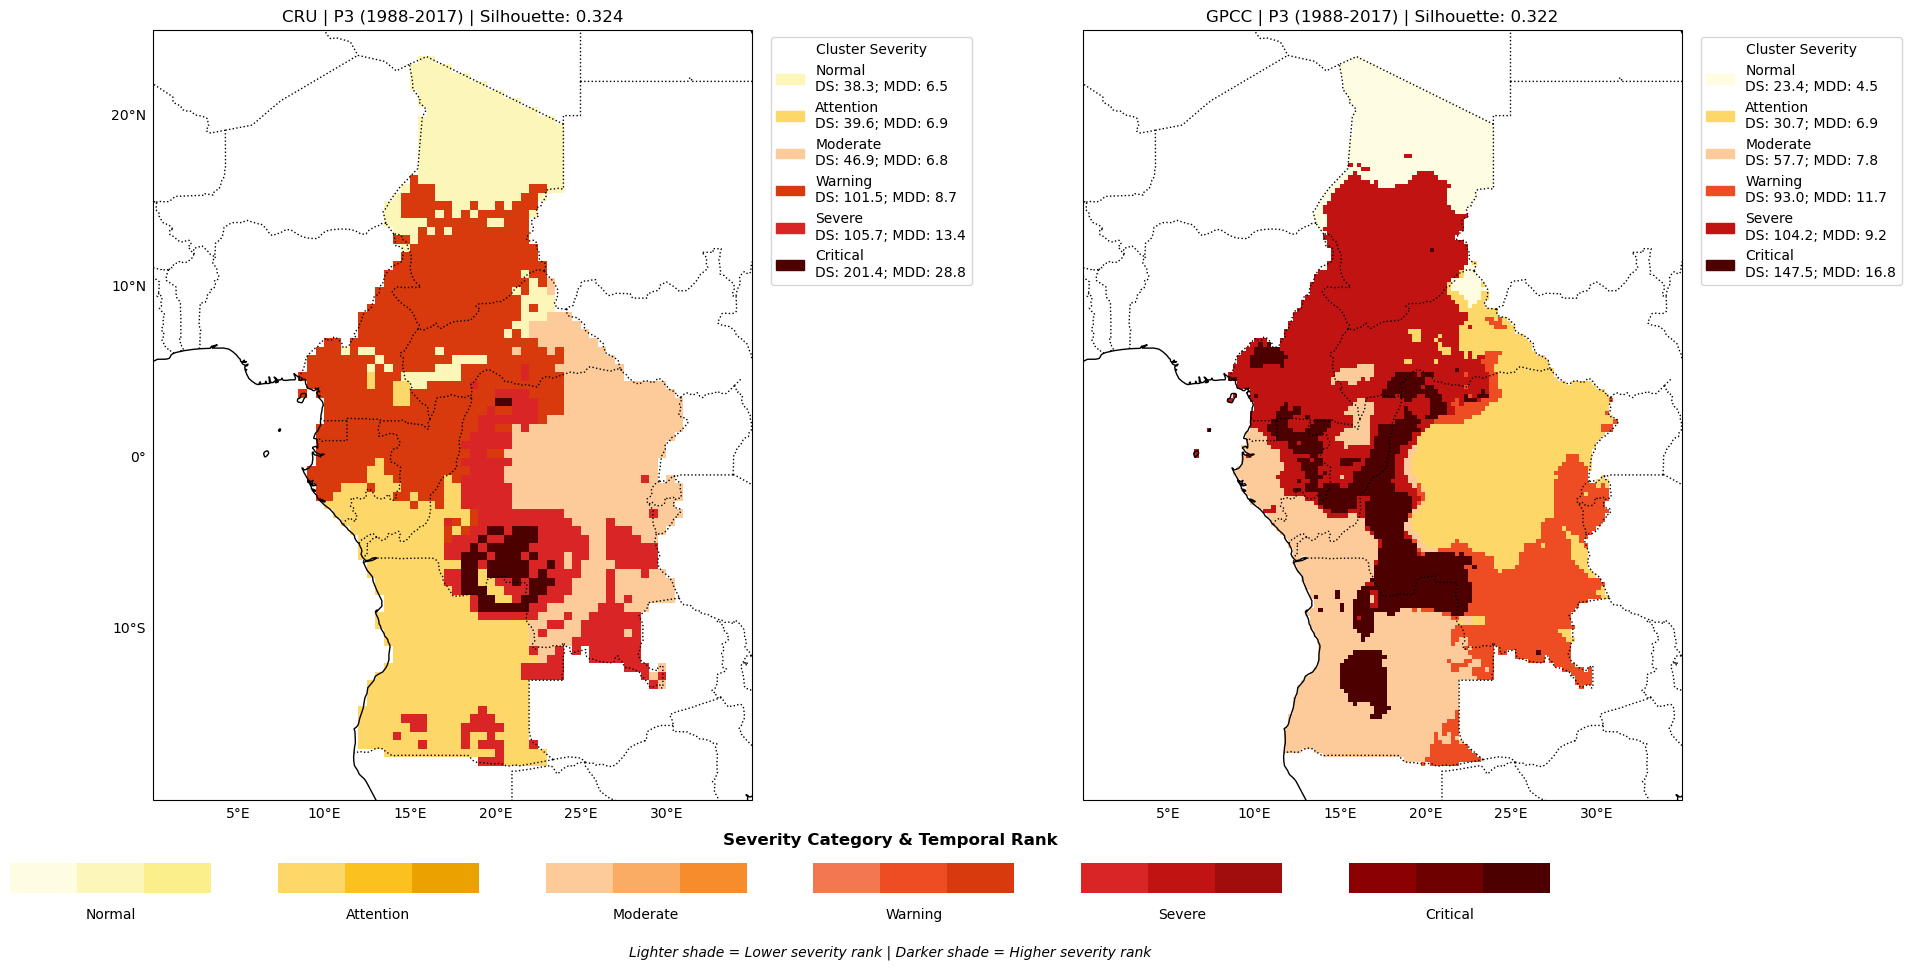

In [69]:
import xarray as xr
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from itertools import groupby
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


# Define the order and specific period to plot (CRU on the left, GPCC on the right)
datasets_to_plot = ['CRU', 'GPCC']
period_to_plot = 'p3'
period_label = '1988-2017' 

fig, axes = plt.subplots(
    1, 2, 
    figsize=(22, 10), 
    subplot_kw={'projection': ccrs.PlateCarree()}
)

#2. Loop through the datasets and plot only the recent period ('p3')
for i, dataset_name in enumerate(datasets_to_plot):
    ax = axes[i]
    
    res = results[dataset_name][period_to_plot]
    labels_da = res['labels_da']
    cluster_labels = res['cluster_labels']
    cluster_means = res['cluster_means']
    sil_score = res['sil_score']
    
    # Create the color palette for the map
    colors_list = [None] * 6
    for cluster_index, label in cluster_labels.items():
        rank = ranks[dataset_name][label][period_to_plot]
        color = color_palettes[label][rank]
        colors_list[cluster_index] = color
    
    valid_colors = [c for c in colors_list if c is not None]
    if not valid_colors: 
        continue
    cmap = ListedColormap(valid_colors)
    
    labels_da.plot(ax=ax, cmap=cmap, add_colorbar=False)
    
    legend_order = ['Normal', 'Attention', 'Moderate', 'Warning', 'Severe', 'Critical']
    label_to_index = {v: k for k, v in cluster_labels.items()}
    
    patches = []
    for label in legend_order:
        if label in label_to_index:
            cluster_index = label_to_index[label]
            rank = ranks[dataset_name][label][period_to_plot]
            color = color_palettes[label][rank]
            metrics = cluster_means[cluster_index]
            legend_text = f"{label}\nDS: {metrics['mean_ds']:.1f}; MDD: {metrics['mean_mdd']:.1f}"
            patch = mpatches.Patch(color=color, label=legend_text)
            patches.append(patch)
    
    ax.legend(handles=patches, loc='upper left', bbox_to_anchor=(1.02, 1), title='Cluster Severity', fontsize='medium')
    
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    
    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.xlines = False
    gl.ylines = False
    gl.top_labels = False
    gl.right_labels = False  
    gl.left_labels = (i == 0)   
    gl.bottom_labels = True
    
    ax.set_xlabel('Longitude (°E)')
    ax.set_ylabel('Latitude (°N)' if i == 0 else '') 
    ax.set_title(f'{dataset_name} | P3 ({period_label}) | Silhouette: {sil_score:.3f}')

# Adjust the figure rectangle to avoid the right caption being cut off
plt.tight_layout(rect=[0, 0.1, 0.9, 0.1]) 
# Add a global horizontal legend below the plots
legend_ax = fig.add_axes([0.1, 0.007, 0.7, 0.05])
legend_ax.set_axis_off()

legend_order = ['Normal', 'Attention', 'Moderate', 'Warning', 'Severe', 'Critical']
num_categories = len(legend_order)
total_units = (num_categories * 3) + (num_categories - 1)
box_width = 1.0 / total_units
space_width = box_width

x_pos = 0
for category in legend_order:
    colors = color_palettes[category]
    category_start_x = x_pos
    for color in colors:
        rect = mpatches.Rectangle((x_pos, 0.2), box_width, 0.6, facecolor=color, edgecolor='none')
        legend_ax.add_patch(rect)
        x_pos += box_width
    label_x_pos = category_start_x + (1.5 * box_width)
    legend_ax.text(label_x_pos, -0.1, category, ha='center', va='top', fontsize=10)
    x_pos += space_width

fig.text(0.5, -0.05, 'Lighter shade = Lower severity rank | Darker shade = Higher severity rank', 
         ha='center', va='bottom', fontsize=10, style='italic')
fig.text(0.5, 0.07, 'Severity Category & Temporal Rank', ha='center', va='center', fontsize=12, weight='bold')

plt.show()

##### ==========================================================================================================================================================================
### SHORT‑TERM SPI FORECASTING WORKFLOW
##### =============================================================================================================================================================
- Device Configuration
- Train/Test Split
- Wavelet Approximation
- Feature Engineering
- Data Flattening & Cleaning
- Data Subsampling & Scaling
- PyTorch DataLoaders
- ANN Model
- WA‑ANN
- Support Vector Regression (SVR)
- Random Forest Baseline

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [76]:
# Load precipitation datasets NetCDF
# ds_cru = xr.open_dataset("../Dataset/CEEAC_cru4.08_pre_1921-2023.nc")
# ds_gpcc = xr.open_dataset("../Dataset/CEEAC_GPCC.v2022_precip_1921-2020.nc")




# # Sélectionner la période 1928–2017
ds_cru = cru_data.sel(time=slice('1928-01-01', '2017-12-31'))
ds_gpcc = gpcc_data.sel(time=slice('1928-01-01', '2017-12-31'))

# Basic exploration


print("\nGPCC Data Info:")
print(ds_gpcc)


GPCC Data Info:
<xarray.Dataset> Size: 653MB
Dimensions:                       (time: 1080, lon: 140, lat: 180)
Coordinates:
  * time                          (time) datetime64[ns] 9kB 1928-01-01 ... 20...
  * lon                           (lon) float64 1kB 0.125 0.375 ... 34.62 34.88
  * lat                           (lat) float64 1kB 24.88 24.62 ... -19.88
Data variables:
    precip                        (time, lat, lon) float32 109MB ...
    numgauge                      (time, lat, lon) float32 109MB ...
    infilled_numgauges            (time, lat, lon) float32 109MB ...
    interpolation_error           (time, lat, lon) float32 109MB ...
    interpolation_error_infilled  (time, lat, lon) float32 109MB ...
    diff_new_old_method           (time, lat, lon) float32 109MB ...
Attributes: (12/20)
    CDI:                       Climate Data Interface version 1.9.8 (https://...
    Conventions:               CF-1.4
    history:                   Sat Mar 15 13:03:58 2025: cdo sellonla

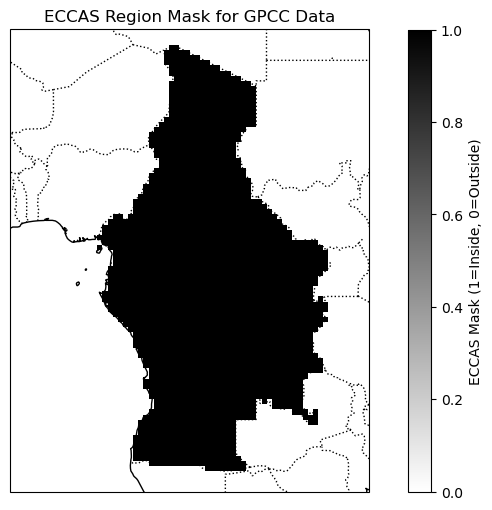

Pays de la CEEAC sélectionnés:
['São Tomé and Principe' 'Rwanda' 'Gabon' 'Eq. Guinea' 'Dem. Rep. Congo'
 'Congo' 'Chad' 'Central African Rep.' 'Cameroon' 'Burundi' 'Angola']

Dimensions des données CRU filtrées:
Temps: 1080 mois
Latitudes: 90 points
Longitudes: 70 points

Dimensions des données GPCC filtrées:
Temps: 1080 mois
Latitudes: 180 points
Longitudes: 140 points


In [77]:
# Combiner toutes les géométries de la CEEAC en une seule
# ceeac_union = ceeac_gdf.geometry.union_all()
ceeac_union = ceeac_gdf.geometry.unary_union


# Créer un masque spatial pour la région CEEAC
def create_ceeac_mask(ds, region_geom):
    """Crée un masque 2D booléen pour la région CEEAC"""
    lon, lat = np.meshgrid(ds.lon.values, ds.lat.values)
    mask = np.zeros(lon.shape, dtype=bool)
    
    for i in range(lat.shape[0]):
        for j in range(lat.shape[1]):
            point = Point(lon[i, j], lat[i, j])
            mask[i, j] = region_geom.contains(point)
    
    return xr.DataArray(mask, dims=('lat', 'lon'), coords={'lat': ds.lat, 'lon': ds.lon})

# Appliquer le masque CEEAC a CRU
ceeac_cru_mask = create_ceeac_mask(ds_cru, ceeac_union)
ds_cru_ceeac = ds_cru.where(ceeac_cru_mask)

# Appliquer le masque CEEAC a GPCC
ceeac_gpcc_mask = create_ceeac_mask(ds_gpcc, ceeac_union)
ds_gpcc_ceeac = ds_gpcc.where(ceeac_gpcc_mask)

# Visualize the mask to verify ECCAS coverage (GPCC)
plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ceeac_cru_mask.plot(ax=ax, cmap='binary', add_colorbar=True, cbar_kwargs={'label': 'ECCAS Mask (1=Inside, 0=Outside)'})
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
plt.title('ECCAS Region Mask for GPCC Data')
plt.show()

# Vérification
print("Pays de la CEEAC sélectionnés:")
print(ceeac_gdf['NAME'].values)

print("\nDimensions des données CRU filtrées:")
print(f"Temps: {len(ds_cru_ceeac.time)} mois")
print(f"Latitudes: {len(ds_cru_ceeac.lat)} points")
print(f"Longitudes: {len(ds_cru_ceeac.lon)} points")

# Pour sauvegarder les données filtrées (optionnel)
ds_cru_ceeac.to_netcdf("CEEAC_cru_filtered.nc")


print("\nDimensions des données GPCC filtrées:")
print(f"Temps: {len(ds_gpcc_ceeac.time)} mois")
print(f"Latitudes: {len(ds_gpcc_ceeac.lat)} points")
print(f"Longitudes: {len(ds_gpcc_ceeac.lon)} points")

# Pour sauvegarder les données filtrées (optionnel)
ds_gpcc_ceeac.to_netcdf("CEEAC_gpcc_filtered.nc")

In [78]:
def spi_1d(arr_1d):
    return indices.spi(
        arr_1d,
        scale,
        distribution,
        start_year,
        start_year,
        end_year,
        periodicity
    )

spi_cru_xr = xr.apply_ufunc(
    spi_1d,
    ds_cru_ceeac["pre"],
    input_core_dims=[["time"]],
    output_core_dims=[["time"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[float],
).rename("spi6_cru")

In [79]:
def spi_1d(arr):
    return indices.spi(
        arr,
        scale,
        distribution,
        start_year,
        start_year,
        end_year,
        periodicity
    )

spi_gpcc_xr = xr.apply_ufunc(
    spi_1d,                         
    ds_gpcc_ceeac["precip"],        
    input_core_dims=[["time"]],     
    output_core_dims=[["time"]],    
    vectorize=True,                 
    dask="parallelized",            
    output_dtypes=[float],          
).rename("spi6_gpcc")


In [80]:
def create_ceeac_mask(ds, region_geom):
    lon, lat = np.meshgrid(ds.lon.values, ds.lat.values)
    mask = np.zeros(lon.shape, dtype=bool)
    for i in range(lat.shape[0]):
        for j in range(lat.shape[1]):
            point = Point(lon[i, j], lat[i, j])
            mask[i, j] = region_geom.contains(point)
    return xr.DataArray(mask, dims=('lat', 'lon'), coords={'lat': ds.lat, 'lon': ds.lon})

ceeac_mask = create_ceeac_mask(ds_gpcc, ceeac_union)
ds_gpcc_ceeac = ds_gpcc.where(ceeac_mask)

spi_gpcc_xr = xr.apply_ufunc(
    spi_1d, ds_gpcc_ceeac["precip"], input_core_dims=[["time"]], output_core_dims=[["time"]],
    vectorize=True, dask="parallelized", output_dtypes=[float]
).rename("spi6_gpcc").transpose('time', 'lat', 'lon')

train_data = spi_gpcc_xr.sel(time=slice('1986-01-01', '2015-12-31'))
test_data = spi_gpcc_xr.sel(time=slice('2016-01-01', '2017-12-31'))

# Wavelet transform for WA-ANN (using Haar wavelet as per Belayneh et al., 2016)
def wavelet_transform(spi_1d, wavelet='haar', level=4, approx_only=True):
    coeffs = pywt.wavedec(spi_1d, wavelet, level=level)
    if approx_only:
        coeffs_approx = [coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]]
        reconstructed = pywt.waverec(coeffs_approx, wavelet)
    else:
        reconstructed = pywt.waverec(coeffs, wavelet)
    if len(reconstructed) > len(spi_1d):
        reconstructed = reconstructed[:len(spi_1d)]
    elif len(reconstructed) < len(spi_1d):
        reconstructed = np.pad(reconstructed, (0, len(spi_1d) - len(reconstructed)), mode='constant')
    return reconstructed

spi_approx = np.full(spi_gpcc_xr.shape, np.nan)
for i in range(spi_gpcc_xr.sizes['lat']):
    for j in range(spi_gpcc_xr.sizes['lon']):
        if ceeac_mask.isel(lat=i, lon=j).item():
            serie = spi_gpcc_xr.isel(lat=i, lon=j).values
            if not np.isnan(serie).all():
                spi_approx[:, i, j] = wavelet_transform(serie, wavelet='haar', level=2, approx_only=True)
spi_approx_xr = xr.DataArray(spi_approx, coords=spi_gpcc_xr.coords, dims=('time', 'lat', 'lon'))

# Create features with lags
def create_features(data_xr, lags=3):
    features = [data_xr.shift(time=lag).fillna(np.nan) for lag in range(1, lags + 1)]
    return xr.concat(features, dim='lag')

In [81]:
lags = 3
features_original = create_features(spi_gpcc_xr, lags)
features_approx = create_features(spi_approx_xr, lags)

# Select train and test data 1986
train_features_original = features_original.sel(time=slice('1986-01-01', '2015-12-31'))
train_target = spi_gpcc_xr.sel(time=slice('1986-01-01', '2015-12-31'))
train_features_approx = features_approx.sel(time=slice('1986-01-01', '2015-12-31'))


test_features_original = features_original.sel(time=slice('2016-01-01', '2017-12-31'))
test_target = spi_gpcc_xr.sel(time=slice('2016-01-01', '2017-12-31'))
test_features_approx = features_approx.sel(time=slice('2016-01-01', '2017-12-31'))

# Flatten and clean data
nt_train, nlat, nlon = train_target.shape
train_features_original_flat = train_features_original.stack(z=('time', 'lat', 'lon')).transpose('z', 'lag').values
train_target_flat = train_target.stack(z=('time', 'lat', 'lon')).values
train_features_approx_flat = train_features_approx.stack(z=('time', 'lat', 'lon')).transpose('z', 'lag').values

valid_train = ~np.isnan(train_features_original_flat).any(axis=1) & ~np.isnan(train_target_flat) & ~np.isnan(train_features_approx_flat).any(axis=1)
X_train = train_features_original_flat[valid_train]
y_train = train_target_flat[valid_train]
X_train_approx = train_features_approx_flat[valid_train]

nt_test = test_target.shape[0]
test_features_original_flat = test_features_original.stack(z=('time', 'lat', 'lon')).transpose('z', 'lag').values
test_target_flat = test_target.stack(z=('time', 'lat', 'lon')).values
test_features_approx_flat = test_features_approx.stack(z=('time', 'lat', 'lon')).transpose('z', 'lag').values

valid_test = ~np.isnan(test_features_original_flat).any(axis=1) & ~np.isnan(test_target_flat) & ~np.isnan(test_features_approx_flat).any(axis=1)
X_test = test_features_original_flat[valid_test]
y_test = test_target_flat[valid_test]
X_test_approx = test_features_approx_flat[valid_test]

# Subset training data for speed
range_to=1000
train_subset = 'all'
if train_subset != 'all' and len(X_train) > train_subset:
    idx = np.random.choice(len(X_train), train_subset, replace=False)
    X_train = X_train[idx]
    y_train = y_train[idx]
    X_train_approx = X_train_approx[idx]

# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_approx = MinMaxScaler()
X_train_approx_scaled = scaler_approx.fit_transform(X_train_approx)
X_test_approx_scaled = scaler_approx.transform(X_test_approx)

# PyTorch DataLoaders
train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

train_dataset_approx = TensorDataset(torch.tensor(X_train_approx_scaled, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader_approx = DataLoader(train_dataset_approx, batch_size=256, shuffle=True)
test_dataset_approx = TensorDataset(torch.tensor(X_test_approx_scaled, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
test_loader_approx = DataLoader(test_dataset_approx, batch_size=256, shuffle=False)

In [82]:

def create_ceeac_mask(ds, region_geom):
    lon, lat = np.meshgrid(ds.lon.values, ds.lat.values)
    mask = np.zeros(lon.shape, dtype=bool)
    for i in range(lat.shape[0]):
        for j in range(lat.shape[1]):
            point = Point(lon[i, j], lat[i, j])
            mask[i, j] = region_geom.contains(point)
    return xr.DataArray(mask, dims=('lat', 'lon'), coords={'lat': ds.lat, 'lon': ds.lon})

ceeac_mask = create_ceeac_mask(ds_gpcc, ceeac_union)
ds_gpcc_ceeac = ds_gpcc.where(ceeac_mask)

spi_gpcc_xr = xr.apply_ufunc(
    spi_1d, ds_gpcc_ceeac["precip"], input_core_dims=[["time"]], output_core_dims=[["time"]],
    vectorize=True, dask="parallelized", output_dtypes=[float]
).rename("spi6_gpcc").transpose('time', 'lat', 'lon')

# Subset data: 30 years train (1986–2015), 2 years test (2016–2017)
train_data = spi_gpcc_xr.sel(time=slice('1928-01-01', '2015-12-31'))
train_data_svr = spi_gpcc_xr.sel(time=slice('1986-01-01', '2015-12-31'))
test_data = spi_gpcc_xr.sel(time=slice('2016-01-01', '2018-12-31'))

# Wavelet transform for WA-ANN (using Haar wavelet as per Belayneh et al., 2016)
def wavelet_transform(spi_1d, wavelet='haar', level=4, approx_only=True):
    coeffs = pywt.wavedec(spi_1d, wavelet, level=level)
    if approx_only:
        coeffs_approx = [coeffs[0]] + [np.zeros_like(c) for c in coeffs[1:]]
        reconstructed = pywt.waverec(coeffs_approx, wavelet)
    else:
        reconstructed = pywt.waverec(coeffs, wavelet)
    if len(reconstructed) > len(spi_1d):
        reconstructed = reconstructed[:len(spi_1d)]
    elif len(reconstructed) < len(spi_1d):
        reconstructed = np.pad(reconstructed, (0, len(spi_1d) - len(reconstructed)), mode='constant')
    return reconstructed

spi_approx = np.full(spi_gpcc_xr.shape, np.nan)
for i in range(spi_gpcc_xr.sizes['lat']):
    for j in range(spi_gpcc_xr.sizes['lon']):
        if ceeac_mask.isel(lat=i, lon=j).item():
            serie = spi_gpcc_xr.isel(lat=i, lon=j).values
            if not np.isnan(serie).all():
                spi_approx[:, i, j] = wavelet_transform(serie, wavelet='haar', level=2, approx_only=True)
spi_approx_xr = xr.DataArray(spi_approx, coords=spi_gpcc_xr.coords, dims=('time', 'lat', 'lon'))

# Create features with lags
def create_features(data_xr, lags=3):
    features = [data_xr.shift(time=lag).fillna(np.nan) for lag in range(1, lags + 1)]
    return xr.concat(features, dim='lag')

lags = 3
features_original = create_features(spi_gpcc_xr, lags)
features_approx = create_features(spi_approx_xr, lags)

# Select train and test data
train_features_original = features_original.sel(time=slice('1986-01-01', '2015-12-31'))
train_target = spi_gpcc_xr.sel(time=slice('1986-01-01', '2015-12-31'))
train_features_approx = features_approx.sel(time=slice('1986-01-01', '2015-12-31'))

test_features_original = features_original.sel(time=slice('2016-01-01', '2017-12-31'))
test_target = spi_gpcc_xr.sel(time=slice('2016-01-01', '2017-12-31'))
test_features_approx = features_approx.sel(time=slice('2016-01-01', '2017-12-31'))

# Flatten and clean data
nt_train, nlat, nlon = train_target.shape
train_features_original_flat = train_features_original.stack(z=('time', 'lat', 'lon')).transpose('z', 'lag').values
train_target_flat = train_target.stack(z=('time', 'lat', 'lon')).values
train_features_approx_flat = train_features_approx.stack(z=('time', 'lat', 'lon')).transpose('z', 'lag').values

valid_train = ~np.isnan(train_features_original_flat).any(axis=1) & ~np.isnan(train_target_flat) & ~np.isnan(train_features_approx_flat).any(axis=1)
X_train = train_features_original_flat[valid_train]
y_train = train_target_flat[valid_train]
X_train_approx = train_features_approx_flat[valid_train]

nt_test = test_target.shape[0]
test_features_original_flat = test_features_original.stack(z=('time', 'lat', 'lon')).transpose('z', 'lag').values
test_target_flat = test_target.stack(z=('time', 'lat', 'lon')).values
test_features_approx_flat = test_features_approx.stack(z=('time', 'lat', 'lon')).transpose('z', 'lag').values

valid_test = ~np.isnan(test_features_original_flat).any(axis=1) & ~np.isnan(test_target_flat) & ~np.isnan(test_features_approx_flat).any(axis=1)
X_test = test_features_original_flat[valid_test]
y_test = test_target_flat[valid_test]
X_test_approx = test_features_approx_flat[valid_test]

# Calculating the number of valid pixels
n_valid_pixels = ceeac_mask.sum().item()  
total_samples = 30 * 12 * n_valid_pixels  # Ex: 30×12×87525 = 3141720

# Subset training data for speed
n_years = 5 #15

range_to=1050300
# train_subset = 12 * n_years * n_valid_pixels 

n_valid_pixels = int(ceeac_mask.sum().item()) # Ex: 87525 pixels
train_subset = 12 * n_years * n_valid_pixels
range_to=train_subset  if train_subset != 'all' else 100000
# Subset training data for speed
if train_subset != 'all' and len(X_train) > train_subset:
    n_months = train_subset // n_valid_pixels
    adjusted_subset = n_months * n_valid_pixels
    
    X_train = X_train[:adjusted_subset]
    y_train = y_train[:adjusted_subset]
    X_train_approx = X_train_approx[:adjusted_subset]

# Scaling
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_approx = MinMaxScaler()
X_train_approx_scaled = scaler_approx.fit_transform(X_train_approx)
X_test_approx_scaled = scaler_approx.transform(X_test_approx)

# PyTorch DataLoaders
train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

train_dataset_approx = TensorDataset(torch.tensor(X_train_approx_scaled, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader_approx = DataLoader(train_dataset_approx, batch_size=256, shuffle=True)
test_dataset_approx = TensorDataset(torch.tensor(X_test_approx_scaled, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
test_loader_approx = DataLoader(test_dataset_approx, batch_size=256, shuffle=False)


ANN Epoch 1/100, Train Loss: 0.3398, Val Loss: 0.1801
ANN Epoch 2/100, Train Loss: 0.3337, Val Loss: 0.1827
ANN Epoch 3/100, Train Loss: 0.3327, Val Loss: 0.1811
ANN Epoch 4/100, Train Loss: 0.3321, Val Loss: 0.1800
ANN Epoch 5/100, Train Loss: 0.3317, Val Loss: 0.1809
ANN Epoch 6/100, Train Loss: 0.3315, Val Loss: 0.1817
ANN Epoch 7/100, Train Loss: 0.3311, Val Loss: 0.1829
ANN Epoch 8/100, Train Loss: 0.3309, Val Loss: 0.1817
ANN Epoch 9/100, Train Loss: 0.3299, Val Loss: 0.1805
ANN Epoch 10/100, Train Loss: 0.3297, Val Loss: 0.1803
ANN Epoch 11/100, Train Loss: 0.3294, Val Loss: 0.1814
ANN Epoch 12/100, Train Loss: 0.3298, Val Loss: 0.1814
ANN Epoch 13/100, Train Loss: 0.3292, Val Loss: 0.1797
ANN Epoch 14/100, Train Loss: 0.3291, Val Loss: 0.1811
ANN Epoch 15/100, Train Loss: 0.3288, Val Loss: 0.1809
ANN Epoch 16/100, Train Loss: 0.3289, Val Loss: 0.1800
ANN Epoch 17/100, Train Loss: 0.3288, Val Loss: 0.1806
ANN Epoch 18/100, Train Loss: 0.3286, Val Loss: 0.1815
ANN Epoch 19/100, T

### ANN Model Architecture

In [ ]:
# ANN Model
class ANN(nn.Module):

    def __init__(self, input_size, hidden_size1=256, hidden_size2=128, hidden_size3=64):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, 1)
        self.dropout = nn.Dropout(0.4)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)
        return self.fc4(x)

#### Train ANN

In [ ]:
# Train ANN
model = ANN(lags).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
num_epochs = 100
patience = 10
best_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(test_loader.dataset)
    val_losses.append(val_loss)
    scheduler.step(val_loss)
    
    print(f"ANN Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'ann_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
        
model.load_state_dict(torch.load('ann_model.pth'))
model.eval()
with torch.no_grad():
    ann_pred = model(torch.tensor(X_test_scaled, dtype=torch.float32).to(device)).cpu().numpy().flatten()
    ann_pred = np.nan_to_num(ann_pred, nan=0.0)
ann_rmse = np.sqrt(mean_squared_error(y_test, ann_pred))
ann_r2 = r2_score(y_test, ann_pred)
print(f"ANN RMSE: {ann_rmse:.3f}, R²: {ann_r2:.3f}")

#### Train WA-ANN

In [ ]:
# Train WA-ANN
model_approx = ANN(lags).to(device)
optimizer_approx = optim.Adam(model_approx.parameters(), lr=0.0001)
scheduler_approx = optim.lr_scheduler.ReduceLROnPlateau(optimizer_approx, 'min', patience=3, factor=0.5)
best_loss = float('inf')
patience_counter = 0
train_losses_approx = []
val_losses_approx = []

for epoch in range(num_epochs):
    model_approx.train()
    running_loss = 0.0
    for inputs, labels in train_loader_approx:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer_approx.zero_grad()
        outputs = model_approx(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer_approx.step()
        running_loss += loss.item() * inputs.size(0)
    train_loss = running_loss / len(train_loader_approx.dataset)
    train_losses_approx.append(train_loss)
    
    model_approx.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader_approx:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_approx(inputs)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item() * inputs.size(0)
    val_loss /= len(test_loader_approx.dataset)
    val_losses_approx.append(val_loss)
    scheduler_approx.step(val_loss)
    
    print(f"WA-ANN Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    if val_loss < best_loss:
        best_loss = val_loss
        patience_counter = 0
        torch.save(model_approx.state_dict(), 'wa_ann_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
        
model_approx.load_state_dict(torch.load('wa_ann_model.pth'))
model_approx.eval()
with torch.no_grad():
    wa_ann_pred = model_approx(torch.tensor(X_test_approx_scaled, dtype=torch.float32).to(device)).cpu().numpy().flatten()
    wa_ann_pred = np.nan_to_num(wa_ann_pred, nan=0.0)
wa_ann_rmse = np.sqrt(mean_squared_error(y_test, wa_ann_pred))
wa_ann_r2 = r2_score(y_test, wa_ann_pred)
print(f"WA-ANN RMSE: {wa_ann_rmse:.3f}, R²: {wa_ann_r2:.3f}")

#### SVR Default

In [ ]:
# SVR Default
empirical_gamma = 'scale'
svr_default = SVR(kernel='rbf', C=5.0, epsilon=0.1, gamma=empirical_gamma)
svr_default.fit(X_train_scaled[:range_to], y_train[:range_to])
joblib.dump(svr_default, 'svr_default_model.joblib')
svr_default_pred = svr_default.predict(X_test_scaled)
svr_default_pred = np.nan_to_num(svr_default_pred, nan=0.0)
svr_default_rmse = np.sqrt(mean_squared_error(y_test, svr_default_pred))
svr_default_r2 = r2_score(y_test, svr_default_pred)
print(f"SVR Default RMSE: {svr_default_rmse:.3f}, R²: {svr_default_r2:.3f}")

#### RGA-SVR

In [ ]:
# RGA-SVR
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

def evaluate_svr(individual):
    C, gamma, epsilon = [max(0.1, x) for x in individual]
    svr = SVR(kernel='rbf', C=C, gamma=gamma, epsilon=epsilon)
    svr.fit(X_train_scaled[:range_to], y_train[:range_to])
    pred = svr.predict(X_test_scaled)
    return mean_squared_error(y_test, pred),

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, 0.1, 10)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=3)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_svr)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=20)
algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.3, ngen=5, verbose=True)
best_individual = tools.selBest(population, k=1)[0]
rga_svr = SVR(kernel='rbf', C=best_individual[0], gamma=best_individual[1], epsilon=best_individual[2])
rga_svr.fit(X_train_scaled[:range_to], y_train[:range_to])
joblib.dump(rga_svr, 'rga_svr_model.joblib')
rga_svr_pred = rga_svr.predict(X_test_scaled)
rga_svr_pred = np.nan_to_num(rga_svr_pred, nan=0.0)
rga_svr_rmse = np.sqrt(mean_squared_error(y_test, rga_svr_pred))
rga_svr_r2 = r2_score(y_test, rga_svr_pred)
print(f"RGA-SVR RMSE: {rga_svr_rmse:.3f}, R²: {rga_svr_r2:.3f}")

### Random Forest

In [ ]:
# Random Forest
rf = RandomForestRegressor(n_estimators=10000, max_depth=15, min_samples_split=10, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
joblib.dump(rf, 'rf_model.joblib')
rf_pred = rf.predict(X_test_scaled)
rf_pred = np.nan_to_num(rf_pred, nan=0.0)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_r2 = r2_score(y_test, rf_pred)
print(f"Random Forest RMSE: {rf_rmse:.3f}, R²: {rf_r2:.3f}")

##### =============================================================================
####  MODEL EVALUATION: Time-Shifted Regional Performance
##### =============================================================================

 This section evaluates the performance of each model on a regional level.
 Crucially, it accounts for the predictive lag by:
 - Shifting the predictions timestamps backward by `lag` months.
 - Aligning the true and predicted series to a common time period.
 This ensures that the calculated metrics (RMSE, R²) are fair and accurate.


In [ ]:
#  Reshape back to spatial form for regional averaging
def to_xarray(pred_flat, template, mask_flat):
    arr = np.full(template.shape, np.nan)
    flat = arr.ravel()
    flat[mask_flat] = pred_flat
    return xr.DataArray(arr, coords=template.coords, dims=template.dims)

ann_spatial    = to_xarray(ann_pred, test_data, valid_test)
wa_ann_spatial = to_xarray(wa_ann_pred, test_data, valid_test)
svr_spatial    = to_xarray(svr_default_pred, test_data, valid_test)
rga_spatial    = to_xarray(rga_svr_pred, test_data, valid_test)
rf_spatial     = to_xarray(rf_pred, test_data, valid_test)

In [ ]:
# Parameters
lag_months = 1

# Prepare Data Dictionaries 
predictions_dict = {
    'ANN': ann_spatial,
    'WA-ANN': wa_ann_spatial,
    'SVR-scale': svr_spatial,
    'RF': rf_spatial,
    'RGA-SVR': rga_spatial,
    'SVR': rf_spatial,
}

# Shift Prediction Timestamps 
# Define a function to shift the time coordinate of a DataArray backward.
# This aligns the prediction for time 't+lag' with the true value at time 't'.
def shift_prediction_times(da_pred, lag):
    """Shifts the time coordinate of a DataArray backward by a number of months."""
    original_index = da_pred.time.to_index()
    shifted_index = original_index - pd.DateOffset(months=lag)
    return da_pred.assign_coords(time=shifted_index)

# Apply the time shift to all model predictions.
shifted_predictions = {
    name: shift_prediction_times(da, lag_months)
    for name, da in predictions_dict.items()
}

# Calculate the true regional average from the test dataset.
true_regional_series = test_data.mean(dim=['lat', 'lon'])

# Find the common time window for all series.
latest_start_date = max(
    [true_regional_series.time.min().values] +
    [da.time.min().values for da in shifted_predictions.values()]
)
earliest_end_date = min(
    [true_regional_series.time.max().values] +
    [da.time.max().values for da in shifted_predictions.values()]
)

# Filter the true series and all predicted series to this common time window.
true_aligned = true_regional_series.sel(time=slice(latest_start_date, earliest_end_date))
predictions_aligned = {
    name: da.sel(time=slice(latest_start_date, earliest_end_date))
    for name, da in shifted_predictions.items()
}

plt.figure(figsize=(14, 7))
plt.plot(true_aligned.time, true_aligned, 'k-', lw=2.5, label='Observed SPI-6')

for name, da in predictions_aligned.items():
    # Calculate the regional mean for the aligned prediction
    regional_pred = da.mean(dim=['lat', 'lon'])
    plt.plot(regional_pred.time, regional_pred, '--', alpha=0.8, label=name)

plt.xlabel('Time', fontsize=12)
plt.ylabel('Regional Mean SPI-6', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

print("\n" + "="*50)
print(f"  REGIONAL PREDICTION METRICS")
print("="*50 + "\n")

true_values = true_aligned.values

for model_name, pred_da in predictions_aligned.items():
    pred_values = pred_da.mean(dim=['lat', 'lon']).values
    
    rmse = np.sqrt(mean_squared_error(true_values, pred_values))
    r2 = r2_score(true_values, pred_values)
    
    print(f"▶ Model: {model_name}")
    print(f"  - R² Score: {r2:.3f}")
    print(f"  - RMSE:     {rmse:.3f}\n")

print("-" * 50)